Dataset loaded and prepared. First few rows:
                  total_expenses  total_revenue  net_transaction
transaction_date                                                
2022-08-18                  0.00         515.00           515.00
2022-08-19               3776.02        3852.29            76.27
2022-08-20                  0.00           0.00             0.00
2022-08-21                  0.00           0.00             0.00
2022-08-22                471.11         380.00           -91.11

Model trained. Summary:
                                       SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  520
Model:             SARIMAX(3, 0, 2)x(2, 0, [1], 7)   Log Likelihood               -4431.724
Date:                             Thu, 05 Dec 2024   AIC                           8883.447
Time:                                     20:16:56   BIC                           8925.985
Sample:       

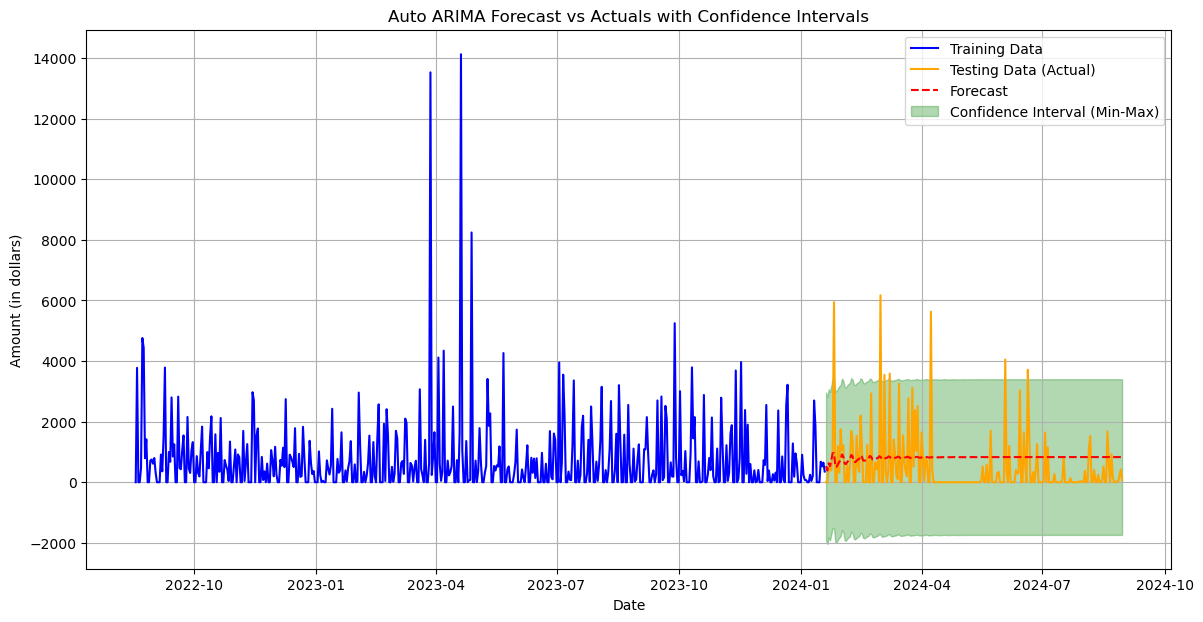

Mean Absolute Error (MAE): 819.19
Mean Squared Error (MSE): 1108243.85
Root Mean Squared Error (RMSE): 1052.73
Total Forecasted Amount: 181230.30
Forecast results saved to 'Expenses_forecast_AutoARIMA.csv'.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

def load_and_prepare_data(filepath, date_column, target_column):
    """
    Load the dataset, parse dates, and set up the target time series.
    """
    data = pd.read_csv(filepath)
    data[date_column] = pd.to_datetime(data[date_column])
    data.set_index(date_column, inplace=True)
    data.sort_index(inplace=True)  # Ensure the data is sorted by date
    print(f"Dataset loaded and prepared. First few rows:\n{data.head()}\n")
    return data[target_column]

def train_auto_arima(timeseries, seasonal=True, season_length=7, **arima_params):
    """
    Train an Auto-ARIMA model on the provided time series.
    """
    model = auto_arima(
        timeseries,
        seasonal=seasonal,
        m=season_length,  # Set season length dynamically
        stepwise=True,
        suppress_warnings=True,
        trace=False,
        **arima_params
    )
    print("Model trained. Summary:\n", model.summary())
    return model

def forecast_with_confidence(model, steps, test_index):
    """
    Generate forecasts and confidence intervals.
    """
    forecast, conf_int = model.predict(n_periods=steps, return_conf_int=True)
    forecast_min = conf_int[:, 0]
    forecast_max = conf_int[:, 1]

    comparison_df = pd.DataFrame({
        'Predicted': forecast,
        'Lower_CI': forecast_min,
        'Upper_CI': forecast_max
    }, index=test_index)
    return comparison_df

def plot_forecast(train, test, comparison_df, title, ylabel):
    """
    Plot the forecast results along with confidence intervals.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(train, label="Training Data", color="blue")
    plt.plot(test, label="Testing Data (Actual)", color="orange")
    plt.plot(comparison_df['Predicted'], label="Forecast", color="red", linestyle="--")
    plt.fill_between(
        comparison_df.index,
        comparison_df['Lower_CI'],
        comparison_df['Upper_CI'],
        color="green",
        alpha=0.3,
        label="Confidence Interval (Min-Max)"
    )
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

def evaluate_forecast(actual, predicted):
    """
    Evaluate the forecast using MAE and MSE.
    """
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    return mae, mse, rmse

def main(filepath, date_column, target_column, train_ratio=0.7, seasonal=True, season_length=7, **arima_params):
    """
    Main pipeline for Auto-ARIMA forecasting.
    """
    # Load and prepare data
    timeseries = load_and_prepare_data(filepath, date_column, target_column)

    # Split into training and testing sets
    train_size = int(len(timeseries) * train_ratio)
    train = timeseries.iloc[:train_size]
    test = timeseries.iloc[train_size:]

    # Train the Auto-ARIMA model
    model = train_auto_arima(train, seasonal=seasonal, season_length=season_length, **arima_params)

    # Forecast for the test set
    comparison_df = forecast_with_confidence(model, steps=len(test), test_index=test.index)
    comparison_df['Actual'] = test.values

    # Plot the forecast results
    plot_forecast(
        train, 
        test, 
        comparison_df, 
        title="Auto ARIMA Forecast vs Actuals with Confidence Intervals",
        ylabel="Amount (in dollars)"
    )

    # Evaluate the forecast
    mae, mse, rmse = evaluate_forecast(comparison_df['Actual'], comparison_df['Predicted'])

    # Total forecasted amount
    total_forecast = comparison_df['Predicted'].sum()
    print(f"Total Forecasted Amount: {total_forecast:.2f}")

    # Save the forecasted results
    output_file = "Expenses_forecast_AutoARIMA.csv"
    comparison_df.to_csv(output_file, index=True)
    print(f"Forecast results saved to '{output_file}'.")

# Run the pipeline dynamically
if __name__ == "__main__":
    FILEPATH = r"C:\upi_data\transactions_single_account.csv"
    DATE_COLUMN = "transaction_date"
    TARGET_COLUMN = "total_expenses"
    main(
        filepath=FILEPATH,
        date_column=DATE_COLUMN,
        target_column=TARGET_COLUMN,
        train_ratio=0.7,
        seasonal=True,  # Set to False if no seasonality
        season_length=7  # Weekly seasonality for daily data
    )
